In this notebook, I used embedding on top of the original seq2seq model. This was also done on the calculations dataset. Accuracy siginificantly decreased in both datasets. In the calculations dataset, generated sentences were still correct but the reddit dataset resorted to blank output sentences. <br>
RMSPROP: Tried to increase training size (does improve acc by 5% in the first 100 epochs, no significant changes in the next 100). Increased lr from 0.001 to 0.01 --> plateaus at 10% after 20 epochs , plateaus after 5 epochs if use 0.1. <br>
ADAM: default lr goes up to 19% acc (but graph looks like its on a steady increase, may go up even more if trained more) 

In [4]:
%cd ..
%cd root
import numpy as np
import pandas as pd
df = pd.read_csv("AL_clean_2.csv")
df.head()
df.fillna('', inplace=True)
print(len(df))
x = df["x1"].tolist()
y = df["y1"].tolist()

/
/root
56297


In [0]:
x = x[:int(len(x)*.6)]
y = y[:int(len(x)*.6)]

In [3]:
df.head()

,Unnamed: 0,x1,y1,x_count,y_count
0,0,what kind of phones do you guys have,i have a it is pretty great much better than w...,8,8
1,1,i have a it is pretty great much better than w...,does it really charge all the way in min,14,14
2,2,does it really charge all the way in min,pretty fast i have never it but it is under ha...,9,9
3,3,what kind of phones do you guys have,samsung galaxy j it is my first cell phone and...,8,8
4,4,samsung galaxy j it is my first cell phone and...,what do you think of it anything you do not like,16,16


In [6]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

# Vectorize the data.
input_texts = []
target_texts = []
input_words = set()
target_words = set()

for line in x:
    input_texts.append(str(line).split(" "))
    for word in str(line).split(" "):
        if word not in input_words:
            input_words.add(word)

for line in y:
  target_texts.append(['\t'] + str(line).split(" ") + ['\n'])
  for word in str(line).split(" "):
    if word not in target_words:
        target_words.add(word)
target_words.add("\t")
target_words.add("\n")
  
input_words = sorted(list(input_words))
target_words = sorted(list(target_words))
num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

# Original Data
# Number of samples: 56297
# Number of unique input tokens: 18207
# Number of unique output tokens: 22006
# Max sequence length for inputs: 63
# Max sequence length for outputs: 34

Using TensorFlow backend.


Number of samples: 33778
Number of unique input tokens: 6840
Number of unique output tokens: 5948
Max sequence length for inputs: 25
Max sequence length for outputs: 27


In [7]:
input_token_index = dict(
    [(word, i) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i) for i, word in enumerate(target_words)])
print(target_token_index)

{'': 0, '\t': 1, '\n': 2, 'a': 3, 'aaa': 4, 'abandoned': 5, 'abba': 6, 'abilities': 7, 'ability': 8, 'able': 9, 'abomination': 10, 'about': 11, 'abouts': 12, 'above': 13, 'absolute': 14, 'absolutely': 15, 'abstract': 16, 'abuse': 17, 'abusive': 18, 'ac': 19, 'academia': 20, 'academy': 21, 'accent': 22, 'accents': 23, 'accept': 24, 'acceptable': 25, 'accepted': 26, 'accepting': 27, 'access': 28, 'accident': 29, 'accidentally': 30, 'accidently': 31, 'accomplish': 32, 'accomplished': 33, 'accomplishment': 34, 'accomplishments': 35, 'according': 36, 'account': 37, 'accounting': 38, 'accounts': 39, 'accurate': 40, 'ace': 41, 'achieve': 42, 'achieved': 43, 'achievement': 44, 'acid': 45, 'acne': 46, 'acoustic': 47, 'acres': 48, 'across': 49, 'act': 50, 'acted': 51, 'acting': 52, 'action': 53, 'actions': 54, 'active': 55, 'activities': 56, 'activity': 57, 'actor': 58, 'actress': 59, 'acts': 60, 'actual': 61, 'actually': 62, 'ad': 63, 'adc': 64, 'add': 65, 'added': 66, 'addict': 67, 'addicted':

In [13]:
word2vec_index = {}
f = open("glove.6B.100d.txt",encoding="utf8")
for line in f:
    words = line.split()
    word = words[0]
    index = np.asarray(words[1:], dtype="float32")
    word2vec_index[word] = index
f.close()

print("The number of word vectors are: ", len(word2vec_index))

The number of word vectors are:  400000


In [14]:
en_embedding_matrix = np.zeros((num_encoder_tokens, 100))
count = 0
count_1 = 0
not_glove = []
for i, word in enumerate(input_words):
    embedding_vector = word2vec_index.get(word)
    if embedding_vector is not None:
        en_embedding_matrix[i] = embedding_vector
        count_1 += 1
    else:
        en_embedding_matrix[i] = np.random.randn(100)
        not_glove.append(word)
        count += 1
print("In GLOVE: {}, Not in GLOVE: {}".format(count_1, count))
# The updated version has 90% of the vocab in glove! Yay!

In GLOVE: 6617, Not in GLOVE: 223


In [15]:
de_embedding_matrix = np.zeros((num_decoder_tokens, 100))
count = 0
count_1 = 0
not_glove = []
for i, word in enumerate(target_words):
    embedding_vector = word2vec_index.get(word)
    if embedding_vector is not None:
        de_embedding_matrix[i] = embedding_vector
        count_1 += 1
    else:
        de_embedding_matrix[i] = np.random.randn(100)
        not_glove.append(word)
        count += 1
print("In GLOVE: {}, Not in GLOVE: {}".format(count_1, count))
# The updated version has 92% of the vocab in glove! Yay!

In GLOVE: 5817, Not in GLOVE: 131


In [0]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, word in enumerate(input_text):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text):
        decoder_input_data[i, t] = target_token_index[word]
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[word]] = 1

In [24]:
from keras.layers import Embedding, TimeDistributed
import tensorflow as tf
EN_Embedding = Embedding(input_dim= num_encoder_tokens, output_dim=100,weights=[en_embedding_matrix],trainable=True)
DE_Embedding = Embedding(input_dim= num_decoder_tokens, output_dim=100,weights=[de_embedding_matrix],trainable=True)

encoder_inputs = Input(shape=(None,), dtype="int32")
encoder_inputs_embed = EN_Embedding(encoder_inputs)
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_embed)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,), dtype="int32")
decoder_inputs_embed = DE_Embedding(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_embed,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# rms = tf.keras.optimizers.RMSprop(
#     learning_rate=0.01
# )
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 100)    684000      input_7[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 100)    594800      input_8[0][0]                    
____________________________________________________________________________________________

In [0]:
# encoder_input_data = np.expand_dims(encoder_input_data, axis=-1)
# decoder_input_data = np.expand_dims(decoder_input_data, axis=-1)

In [25]:
hist = model.fit([encoder_input_data[:int(len(input_texts)*.9)], decoder_input_data[:int(len(input_texts)*.9)]], decoder_target_data[:int(len(input_texts)*.9)],
          batch_size=128,
          epochs=100,
          validation_split=0.05)

model.save('al_m2_reddit_v3.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 28880 samples, validate on 1520 samples
Epoch 1/100
28880/28880 [==============================] - 53s 2ms/step - loss: 1.3357 - accuracy: 0.0298 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
28880/28880 [==============================] - 52s 2ms/step - loss: 1.2095 - accuracy: 0.0397 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/100
28880/28880 [==============================] - 52s 2ms/step - loss: 1.1549 - accuracy: 0.0438 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/100
28880/28880 [==============================] - 52s 2ms/step - loss: 1.1166 - accuracy: 0.0462 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/100
28880/28880 [==============================] - 52s 2ms/step - loss: 1.0859 - accuracy: 0.0481 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/100
28880/28880 [==============================] - 52s 2ms/step - loss: 1.0607 - accuracy: 0.0495 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/100
288

In [0]:
from google.colab import files
files.download('al_m2_reddit_v3.h5')

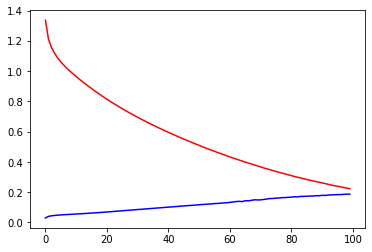

In [26]:
import matplotlib.pyplot as plt
plt.plot(hist.history["loss"], color='r')
plt.plot(hist.history["accuracy"], color='b')
# observations: val loss and val acc not increase/decreasing, not learning anything!
# observations: acc seems to be plateauing, not sure if will even increase after more epochs
# time distributed has around the same acc
# setting dimensions to none made acc go up by at least 3% (to 15%) !?
# increased training size --> acc went up to 20% per 100 epochs
# https://github.com/devm2024/nmt_keras/blob/master/base.ipynb

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

embed_decoder_inputs = DE_Embedding(decoder_inputs)

decoder_outputs1, state_h1, state_c1 = decoder_lstm(
    embed_decoder_inputs, initial_state=decoder_states_inputs)

decoder_states1 = [state_h1, state_c1]
decoder_outputs1 = decoder_dense(decoder_outputs1)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs1] + decoder_states1)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


In [1]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_token_index['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(int(len(input_texts)*.9),int(len(input_texts)*.9)+10 ):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

NameError: ignored